**В задании предлагается с помощью Pandas ответить на несколько вопросов по данным репозитория UCI [Adult](https://archive.ics.uci.edu/ml/datasets/Adult).**

Уникальные значения признаков (больше информации по ссылке выше):
- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.   
- salary: >50K,<=50K

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('adult.data', skipinitialspace=True)
data.columns = ['age',
                'workclass',
                'fnlwgt',
                'education',
                'education_num',
                'marital_status',
                'occupation',
                'relationship',
                'race',
                'sex',
                'capital_gain',
                'capital_loss',
                'hours_per_week',
                'native_country',
                'salary']
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


## Блок на обработку фич (в одном пайплайне)

1. Стандартизируйте признаки age, hours-per-week
2. Закодируйте признаки education, relationship, salary при помощи LabelEncoder/OneHotEncoder
3. Создайте свой эстиматор с методами fit,tranform,fit_transform, который заменяет выбросы на медиану. Выбросы определите как z-score>3. Примените его для полей capital-gain, capital-loss
4. Соберите все преобразования в один пайплайн с помощью ColumnTransformer и примените его к выборке


In [3]:
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from scipy import stats
import numpy as np

In [4]:
class LabelEncoderPipFr(LabelEncoder):
    
    def fit(self, X, y=None):
        super(LabelEncoderPipFr, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipFr, self).transform(X).reshape(-1, 1)
    
    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipFr, self).fit(X).transform(X).reshape(-1, 1)

In [5]:
class OutLiersAreGone(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        values = [x[0] for x in X.iloc(0)]        
        self.no_outliers = [value if np.abs(z) < 3 else np.nan for value, z in zip(values, stats.zscore(values))]
        return self
    
    def transform(self, X, y=None):
        return np.array(self.no_outliers).reshape(-1, 1)
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [18]:
pipeline = make_union(*[
    make_pipeline(FunctionTransformer(lambda df: df[['age', 'hours_per_week']],validate=False),
                  SimpleImputer(strategy='median'),
                  MinMaxScaler()),
    make_pipeline(FunctionTransformer(lambda df: df[['education']], validate=False),
                  LabelEncoderPipFr()),
    make_pipeline(FunctionTransformer(lambda df: df[['relationship']], validate=False),
                  LabelEncoderPipFr()),
    make_pipeline(FunctionTransformer(lambda df: df[['salary']], validate=False),
                  LabelEncoderPipFr()),
    make_pipeline(FunctionTransformer(lambda df: df[['capital_gain']], validate=False),
                  OutLiersAreGone()),
    make_pipeline(FunctionTransformer(lambda df: df[['capital_loss']], validate=False),
                  OutLiersAreGone())
])

In [19]:
pipeline.fit_transform(data)

c:\users\rc199\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[4.52054795e-01, 1.22448980e-01, 9.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.87671233e-01, 3.97959184e-01, 1.10000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.93150685e-01, 3.97959184e-01, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.61643836e-01, 3.97959184e-01, 1.10000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.84931507e-02, 1.93877551e-01, 1.10000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.79452055e-01, 3.97959184e-01, 1.10000000e+01, ...,
        1.00000000e+00, 1.50240000e+04, 0.00000000e+00]])

In [206]:
preprocessor = ColumnTransformer([
        ('standardize', Pipeline(steps=[('median', SimpleImputer(strategy='median')), ('standardize', MinMaxScaler())]), ['age', 'hours_per_week']),
        ('label1', LabelEncoderPipFr(), ['education']),
        ('label2', LabelEncoderPipFr(), ['relationship']),
        ('label3', LabelEncoderPipFr(), ['salary']),
        ('outliers1', OutLiersAreGone(), ['capital_gain']),
        ('outliers2', OutLiersAreGone(), ['capital_loss'])])

In [207]:
pip_ready = Pipeline(steps=[('preprocessor', preprocessor)])

In [208]:
pip_ready.fit_transform(data)

c:\users\rc199\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[4.52054795e-01, 1.22448980e-01, 9.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.87671233e-01, 3.97959184e-01, 1.10000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.93150685e-01, 3.97959184e-01, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.61643836e-01, 3.97959184e-01, 1.10000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.84931507e-02, 1.93877551e-01, 1.10000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.79452055e-01, 3.97959184e-01, 1.10000000e+01, ...,
        1.00000000e+00, 1.50240000e+04, 0.00000000e+00]])

**Постройте гистограмму распределения (bar plot) образования людей (признак education).**

<AxesSubplot:>

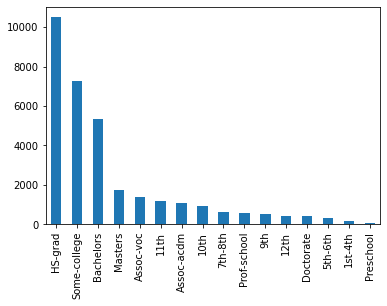

In [18]:
data.education.value_counts().plot.bar()

**Среди кого больше доля зарабатывающих много(>50K): среди женатых или холостых мужчин (признак marital-status)?**

In [25]:
status_married = ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']
married_men = data[(data.sex == 'Male') & (data.marital_status.apply(lambda status: status in status_married))]
not_married_men = data[(data.sex == 'Male') & (data.marital_status.apply(lambda status: status not in status_married))]

rich_married_men = married_men[married_men.salary == '>50K']
rich_not_married_men = not_married_men[not_married_men.salary == '>50K']

print(len(rich_married_men) / len(married_men))
print(len(rich_not_married_men) / len(not_married_men))

0.4405139945351156
0.08450533462657614


In [26]:
rich_married_men

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
6,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
9,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
10,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K
13,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32531,34,Private,204461,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K
32532,54,Private,337992,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,50,Japan,>50K
32538,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
32553,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K


**Какое максимальное число часов человек работает в неделю (признак hours-per-week)? Сколько людей работают такое количество часов и каков среди них процент зарабатывающих много?**

In [35]:
data.hours_per_week.max()

99

In [39]:
len(data[data.hours_per_week == data.hours_per_week.max()])

85

In [42]:
len(data[(data.hours_per_week == data.hours_per_week.max()) & (data.salary == '>50K')]) / len(data[data.hours_per_week == data.hours_per_week.max()])

0.29411764705882354

**Посчитайте среднее время работы (hours-per-week) зарабатывающих много и мало (salary) для каждой страны (native-country).**

In [43]:
pd.crosstab(index=data.native_country, columns=data.salary, values=data.hours_per_week, aggfunc='mean')

salary,<=50K,>50K
native_country,,
?,40.164760,45.547945
Cambodia,41.416667,40.000000
Canada,37.914634,45.641026
China,37.381818,38.900000
Columbia,38.684211,50.000000
Cuba,37.985714,42.440000
Dominican-Republic,42.338235,47.000000
Ecuador,38.041667,48.750000
El-Salvador,36.030928,45.000000
